# Priors, Likelihoods, Posteriors, and All That: Problems

## Problem 1: The Curse of Dimensionality; or why self driving cars are hard.

### 1a) Sampling in low dimensions

Generate a sample of 100 randomly distributed points inside a 2D square. 

### 1b) Distances in low dimensions

Calculate the pairwise distances between all of the points, in d-dimensions, for two points x_i and y_i, this quantity is

$$ |x - y| = \sqrt{\Sigma^d (x_i - y_i)^2} $$

### 1c) Distribution of distances in low dimensions 

Plot the distribution of these distances. Do you notice anything interesting? Is a "special value" picked out?

### 1d) Extending to d-dimensions

Now, let's consider the difference between picking a point located in a d-dimensional sphere vs in a d-dimensional cube. To do this, calculate and plot the the difference between the volume of a cube with unit-length sides and the volume of a unit-radius sphere as the dimension d of the space increases. Possibly helpful formula: 

$$ Sphere: V_d = \frac{\pi^{d/2}}{\frac{d}{2} \Gamma(\frac{d}{2})} $$

$$ Cube: V_d = L^d $$

The proof of this formula is left as an exercise to the reader. (actually, a link to the proof for the curious will be provided in the solutions version of this notebook.

### 1e) Sampling in d-dimensions

Now, consider the problem of sampling in high-dimensions. If we use a uniform prior on every parameter, our expectation is that we will well sample the parameter space simply by picking in a "uniform way". Calculate the ratio of volume contained in an annulus between $R$ and $R - \epsilon$ for d = 1-20 and plot this. Interpret your result in terms of a sampling problem. Are uniform priors a good choice in higher dimensions? Why or why not?

### 1f) Further reading: "Soap bubbles" or "moldy spheres". 

A recent blogpost that discusses an extension of this idea to a Gaussian distribution (rather than uniform unit ball distributions) is here: give it a short read. 

In [178]:
# 1a) Random points in 2D

import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.rand(2, 100)


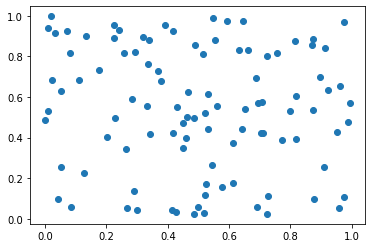

In [179]:
plt.scatter(x, y)

In [180]:
# 1b) calculate pairwise distances for x, y

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

Text(0, 0.5, 'counts')

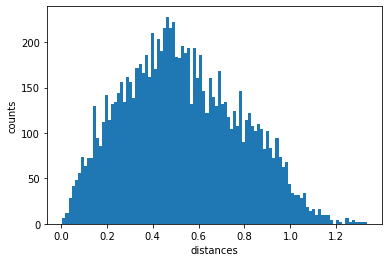

In [181]:
distance_list = []

for pt1 in np.array(list(zip(x,y))):
    for pt2 in np.array(list(zip(x,y))):
        if distance(pt1, pt2) > 0:
            distance_list.append(distance(pt1, pt2))
            
plt.hist(distance_list, bins = 100)
plt.xlabel('distances')
plt.ylabel('counts')

/var/folders/l8/2kslmt113c99klvtjpdbnghm0000gn/T/ipykernel_46202/1596603538.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.pi**(d/2) / ((d/2)*gamma(d/2))


Text(0.5, 0, 'dimensions')

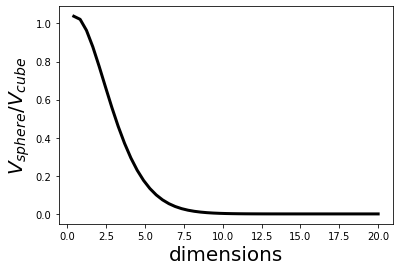

In [170]:
from scipy.special import gamma 

def V_d_sphere(d):
    return np.pi**(d/2) / ((d/2)*gamma(d/2))

def V_d_cube(d):
    return 2**d

Ratios = []
dimensions = np.linspace(0, 20)

for d in dimensions:
    Ratios.append(V_d_sphere(d)/V_d_cube(d))

plt.plot(dimensions, Ratios, lw = 3, color = 'k')
plt.ylabel('$V_{sphere}$/$V_{cube}$', fontsize = 20)
plt.xlabel('dimensions', fontsize = 20)

Text(0.5, 0, 'dimensions')

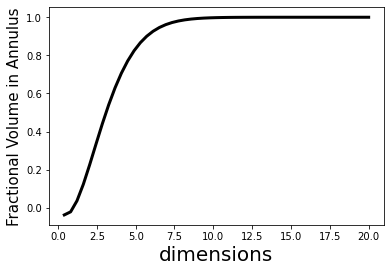

In [176]:
# after some pen and paper math, it becomes clear that this ratio is simply (1-\epsilon)^d

def ratio(d, epsilon):
    return (1 - epsilon)**d

ratio_list = []

for d in dimensions: 
    ratio_list.append(ratio(d, 0.1))
    
plt.plot(dimensions, 1-np.array(Ratios), lw = 3, color = 'k')
plt.ylabel('Fractional Volume in Annulus', fontsize = 15)
plt.xlabel('dimensions', fontsize = 20)

## Problem 2: Measuring distances - when priors matter

A famous example where your choice of prior matters is found in parallax measurements. In this problem, we will explore this. 

(Thank you Adrian Price-Whelan for contributing this problem!) 

In [1]:
# import statements

import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import arviz as az
from astroquery.gaia import Gaia
import pymc as pm

In [2]:
# query Gaia 
# Cohort 5 students should confirm that they understand the database syntax here based on 
# the material from Session 15.
# Cohort 6 students - we will cover this in Session 21 : ) 

job = Gaia.launch_job(
    "SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE parallax_over_error > 3 and parallax_over_error < 4"
)
data = at.QTable(job.get_results().filled())

In [3]:
# print the data - make sure you understand its structure

data['parallax', 'parallax_error'] 

parallax,parallax_error
mas,mas
float64,float32
0.4755467506529697,0.1585155725479126


In [4]:
# now let's consider two choices of prior. First, a uniform prior, and then a truncated normal. 

def uniform_space_density_logp(L):
    def lpdf(r):
        return (2*pm.math.log(r)) - 3*pm.math.log(L) - pm.math.log(2) - r/L
    return lpdf

with pm.Model() as model:
    r = pm.DensityDist(
        'r', 
        logp=uniform_space_density_logp(4.), 
        initval=1.,
        transform=pm.distributions.transforms.LogTransform()
    )
    plx = pm.Normal(
        'plx',
        mu=1/r,
        sigma=data['parallax_error'][0].to_value(u.mas),
        observed=data['parallax'][0].to_value(u.mas)
    )
    
    samples_usd = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r]


/Users/bryan/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/bryan/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.


In [5]:
with pm.Model() as model:
    r = pm.TruncatedNormal(
        'r', 
        mu=2.,
        sigma=1.,
        lower=0,
        initval=1.,
        transform=pm.distributions.transforms.LogTransform()
    )
    plx = pm.Normal(
        'plx',
        mu=1/r,
        sigma=data['parallax_error'][0].to_value(u.mas),
        observed=data['parallax'][0].to_value(u.mas)
    )
    
    samples_truncnorm = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r]


/Users/bryan/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/bryan/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/bryan/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


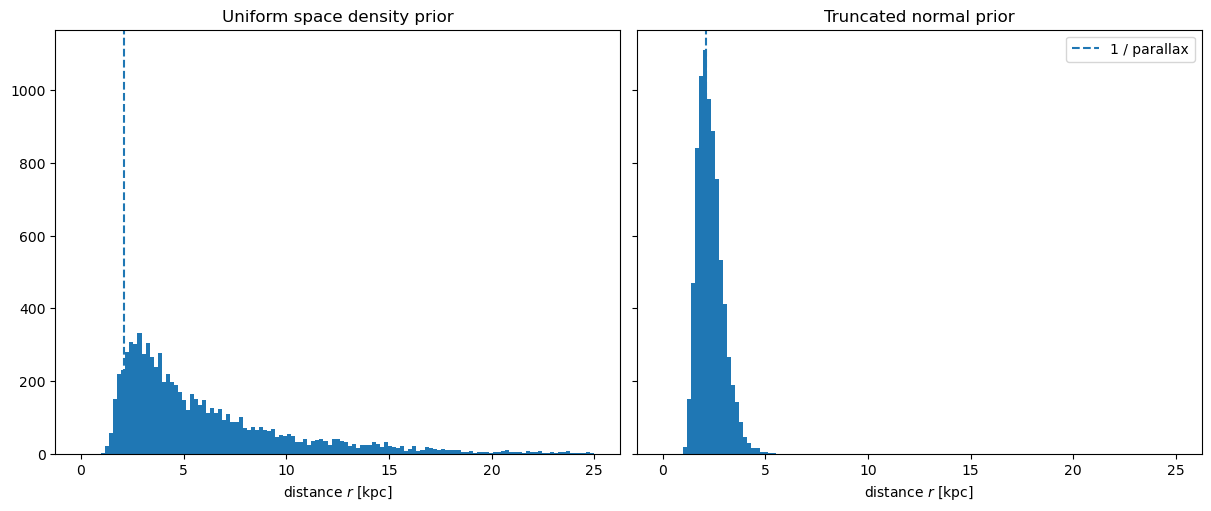

In [6]:
# And plot the results

bins = np.linspace(0, 25, 128)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), 
                         sharex=True, sharey=True, 
                         constrained_layout=True)

ax = axes[0]
ax.hist(
    samples_usd.posterior.r.data.ravel(), 
    bins=bins
)
ax.set_title('Uniform space density prior', fontsize=12)

ax = axes[1]
ax.hist(
    samples_truncnorm.posterior.r.data.ravel(), 
    bins=bins
)
ax.set_title('Truncated normal prior', fontsize=12)

for ax in axes:
    ax.axvline(
        1 / data['parallax'].value, 
        color='tab:blue', 
        linestyle='--', 
        label='1 / parallax'
    )
    ax.set_xlabel('distance $r$ [kpc]')

ax.legend(loc='best')

## Problem 3: Not everything is Gaussian

In the lecture and challenge problems, we've emphasized the importance of the Gaussian distribution. This distribution is very common, but not universal. In a (perhaps apocryphal story) this problem was given to first year students at Cambridge in the 1980s. It concerns estimating the distance to an off-shore lighthouse based on the timing of pulses. A canonical statement of the problem is, 

"A lighthouse is situated at unknown coordinates $x_0,y_0$ with respect to a straight coastline y=0. It sends a series of N flashes in random directions, and these are recorded on the coastline at positions $x_i$." 

### Problem 3-0) Draw the picture. 

With your partner, draw the picture.

### Problem 3a) Prior 

Write down a prior for the $x_0, y_0$ position of the lighthouse. Implement a python function that returns a uniform probability (or if you'd like, another prior) for $x_0, y_0$. Hint: It is easier to write the prior in terms of the angle $\theta$ between the line connecting the lighthouse to the shore and the direction in which the pulse is emitted. 

### Problem 3b) Likelihood 

Now, we need to determine the form of the likelihood. If you following the hint in 3a), we want to turn a function of the data (shoreline positions, x) in terms of the angle ($\theta$). First, write down the relationship between the $x_0$ position of the lighthouse, the data x, and the angle ($\theta$). 

### Problem 3c) Generate some data

In order to produce a Bayesian estimate of the x-y position, we'll need some data. 

### Problem 3d) Posterior

Using Bayes' theorem, write down the posterior. Implement a grid search function to calculate the posterior for the x-y position of the lighthouse. 


### Problem 3e) [Optional] Challenge: Is your likelihood a Gaussian? What is special about your likelihood?

One property of a Gaussian that makes it "special" is that it is the maximum entropy distribution for for finite first and second moments. Calculate the first and second moments of your likelihood distribution. What makes this distribution special? Generate some example plots of your likelihood function and compare to a Gaussian distribution over the same range. Are these curves the same? What is different about them?

In [11]:
from numpy.random import uniform 
import matplotlib.pyplot as plt

In [12]:
import numpy as np

In [159]:
# unknown true values of the position 

x_0 = 10
y_0  = 30

# generate data

thetas = uniform(-np.pi/2,np.pi/2, 100)

def make_data(x, y, thetas): 
    return y * np.tan(thetas) + x

xs = make_data(x_0, y_0, thetas)

In [160]:
def ln_posterior(x_0, y_0, x):
    log_posterior = np.log((y_0/np.pi) * 1/ (y_0**2 + (x - x_0)**2))
    return log_posterior

In [161]:
def grid_search(x_0_grid, y_0_grid, datum): 
    M, B = np.meshgrid(x_0_grid, y_0_grid)

    posterior_grid = np.zeros(M.shape)
    for i, m, in enumerate(M): 
        for j, b in enumerate(B): 
            posterior_grid[i,j] = ln_posterior(m[i], b[j], datum)
    
    return posterior_grid 

In [162]:
x_0_grid = np.linspace(0, 50, 250)
y_0_grid = np.linspace(0, 50, 250)

posterior = np.zeros((len(x_0_grid), len(y_0_grid)))

In [163]:
for data in xs: 
    posterior += grid_search(x_0_grid, y_0_grid, data)

/var/folders/l8/2kslmt113c99klvtjpdbnghm0000gn/T/ipykernel_46202/128402724.py:2: RuntimeWarning: divide by zero encountered in log
  log_posterior = np.log((y_0/np.pi) * 1/ (y_0**2 + (x - x_0)**2))


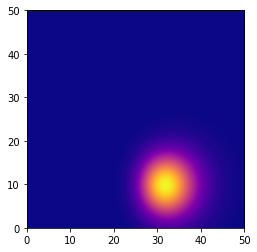

In [165]:
plt.imshow(np.exp(posterior), extent = (0, 50, 0, 50), origin = 'lower', cmap = 'plasma')

## [Pen & Paper] Challenge Problem 1: The Gaussian Derivation of the Central Distribution

In the lecture, we see two derivations of the Central distribution based on physical arguments. The first, spatial homogeneity, arose to solve a problem in astronomy, while the second based on convolutions of distributions (and "additive physical processes" arose in condensed matter physics and electrical engineering. In this problem, we'll study another derivation that also arose in the fitting of the orbits of the planets. 

### Maximum Likelihood Estimates

Begin by reviewing the discussion in Adam's lecture yesterday of the "maximum likelihood estimate" of a parameter. Then, write a general expression for the maximum of the log-likelihood. Then re-express your MLE statmeent in terms of a function $g'(\hat{\theta} - x$), where $\hat{\theta}$ is your MLE estimate for the parameter $\theta$ and $g(\theta-x) = log f(x_i | \theta)$ is your log-likelihood.

### The arithmetic mean and roots of the MLE

Now assume that the MLE must be given by the arithmetic mean of the observations, 

$$ \hat{\theta} = \bar{x} = \frac{1}{n+1} \Sigma_{i=0}^n x_i $$ and consider a simple sample. This sample should have one observation $x_0 = (n+1)(\theta - x)$. Now compute $\hat{\theta}$ and $\hat{\theta} - x_0$. What is the value of $g'(\hat{\theta} - x$)? Is this symmetric or anti-symmetric?

### Functional equations

Given your expression for $g'(\hat{\theta} - x)$, do some functional analysis. What are the possible functional forms of $g(u)$? Then plug them into your original MLE expression. You will find that 

$$ f(x|\theta) = \sqrt{\frac{\alpha}{2\pi}} \exp \left[ -  \frac{1}{2} \alpha (x-\theta)^2 \right]$$

As noted in the lecture, the historical importance of this result is that the assumption that $\hat{\theta} = \bar{x}$ provides a theoretical basis for the intuitive notion that errors cancel. This put to rest a long running argument about the nature of additive errors and justifies much of what we assume as a matter of course.

## [Hybrid] Challenge Problem 2: Deriving the Central Limit Theorem

If you consult the wikipedia page on the central limit theorem, you will find the following definition,

If $X_1, X_2,...,X_n$ are random samples drawn from a population with mean $\mu$ and variance $\sigma^2$, and if $\bar{X}_n$ is the sample mean of the first n samples, then the limiting form of the distribution $Z = \frac{(\bar{X}_n - \mu)}{\sigma_{\bar{X}_n}}$ with standard error of the mean, $\sigma_{\bar{X}_n} = \sigma/n$ is normally distributed.

However, in fact there are many central limit theorems for different distributions. A more general way to approach CLTs is via a form that may be more intuitive as a Bayesian who thinks more about distributions rather than estimators. 

In this form, a statement of the CLT is that, 

If you have a large number of distributions, labelled $f_i = (f_1, f_2, ... f_n)$ and take their convolution $F^{*} = f_1 * f_2 * ... * f_n$, that $F^{*} \rightarrow \mathscr{N}$ as $n \rightarrow \infty$. 

### [Computational] Challenge Problem 2a) Convolutions of distributions

Begin by computing and visualizing the convolution of n-arbitrary distributions. Look up statistical tests for normality and prove to yourself that the resulting distribution really is normal (and becomes increasingly normal as $n \rightarrow \infty$. Try some pathological cases. Can you break the CLT? What caveats should we add to our version of the CLT?

### [Pen & Paper] Challenge Problem 2b) Proof with Fourier Transforms and Cumulants

Now that you've convinced yourself of the CLT by convolving distributions, prove the CLT using pen & paper. One way to do this is by considering

$$ \phi(\alpha) = \int_{-\infty}^{\infty} f(x) \exp \left[ i \alpha x \right] $$ 

then repeating convolution of the function f(x) yields,

$$ h_n (y) = f * f * ... * f = \frac{1}{2\pi} \int_{-\infty}^{\infty} dy \phi(y)^n \exp \left[ i \alpha y \right] $$ 

Now, complete the proof by first considering the quantity $\phi(\alpha)^n$ and performing a cumulant expansion of this quantity. After plugging in, perform the integral. You will find tha the resulting distribution is,

$$ h_n (y) = \frac{1}{\sqrt{2 \pi n \sigma^2}} exp \left( - \frac{(y - n <x> x)^2}{2 n \sigma^2} \right)$$

which proves the CLT. Confirm that the pen and paper derivation respects the conditions you worked out in 2a) for the CLT to be valid.